# Characterize High v. Low conf "branchpoints"

In [2]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [3]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [4]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [5]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [6]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [7]:
import pandas
mercer = pandas.ExcelFile('../anno/mercer.Supplemental_TableS1.xlsx')
print mercer.sheet_names
support = mercer.parse('Split-Invert Alignment')
supp = {}
for chrom, pos, strand in zip(support['Chromosome'], support['Start'], support['Strand']):
    if chrom not in supp: supp[chrom] = {}
    supp[chrom][pos] = 1

[u'Match Only', u'Match+Error', u'Match+Insertion', u'Match+Deletion', u'Split-Invert Alignment']


In [8]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y_high, y_low, chroms, coords, strands = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y_high = np.zeros((stop - begin,))
        for bp in bps:
            assert int(bp) in supp[chrom]
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y_high[bp] = 1
         
        _y_low = np.zeros((stop - begin,))
        for i in range(L):
            if strand == '+':
                coord = three - L + i
            else:
                coord = L - i + three - 1
            if (not _y_high[i]) and (coord in supp[chrom]):
                _y_low[i] = 1
        y_high += [_y_high]
        y_low  += [_y_low]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y_high), np.vstack(y_low),
            np.array(chroms), np.array(coords), np.array(strands))

(X, y_high, y_low, chroms, coords, strands) = encode(known, phastcons, phylop)

print np.sum(y_high), np.sum(y_low)
print X.shape

56808.0 35895.0
(37110, 70, 6)


In [9]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [10]:
preds = model.predict(X[:, :, :4])

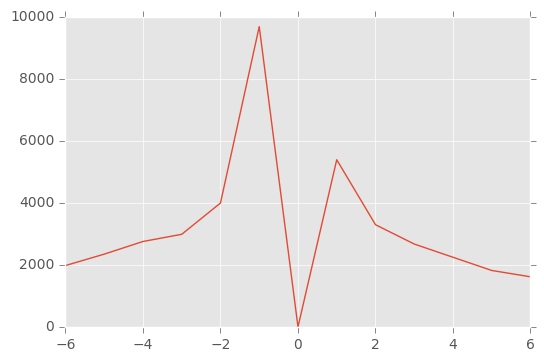

In [11]:
counts = np.zeros((13,))
for low, high in zip(y_low, y_high):
    for bp in np.array(range(L))[high == 1]:
        for shift in range(-6, 7):
            if not 0 < bp+shift < L: continue
            counts[shift+6] += low[bp+shift]
plt.plot(range(-6, 7), counts)
plt.show()

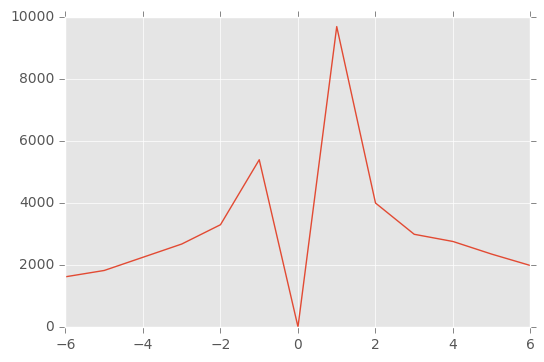

In [12]:
counts = np.zeros((13,))
for low, high in zip(y_low, y_high):
    for bp in np.array(range(L))[low == 1]:
        for shift in range(-6, 7):
            if not 0 < bp+shift < L: continue
            counts[shift+6] += high[bp+shift]
plt.plot(range(-6, 7), counts)
plt.show()

56808.0


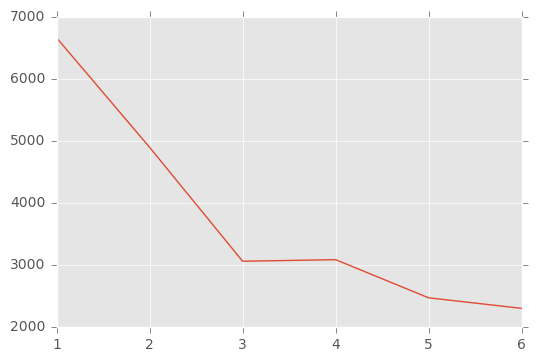

In [16]:
counts = np.zeros((6,))
for low, high in zip(y_low, y_high):
    for bp in np.array(range(L))[high == 1]:
        for shift in range(1, 7):
            if shift == 0: continue
            if not 0 < bp+shift < L: continue
            counts[shift-1] += high[bp+shift]
print np.sum(y_high)
plt.plot(range(1, 7), counts)
plt.show()

## Conservation Meta

56617
33409
14703
4458


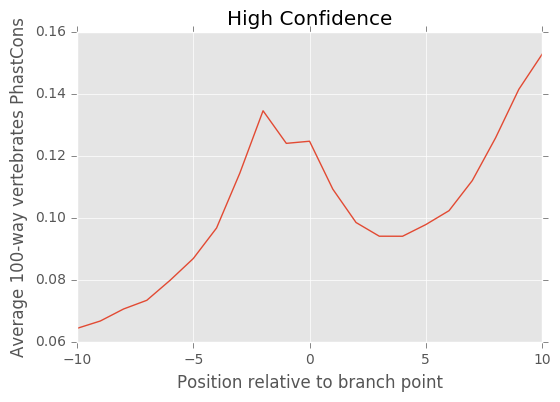

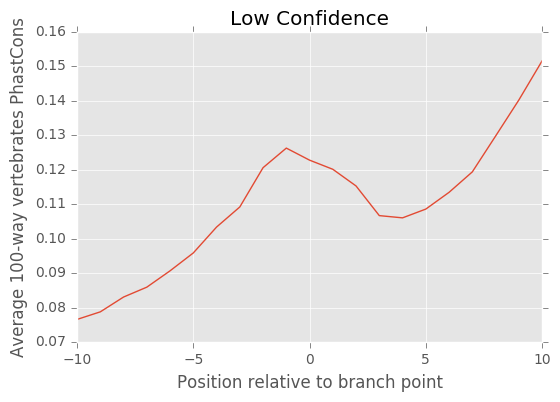

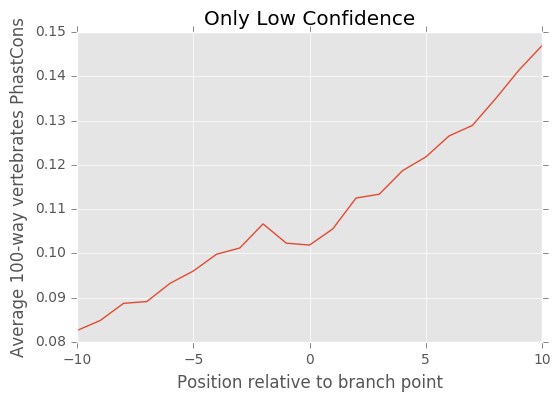

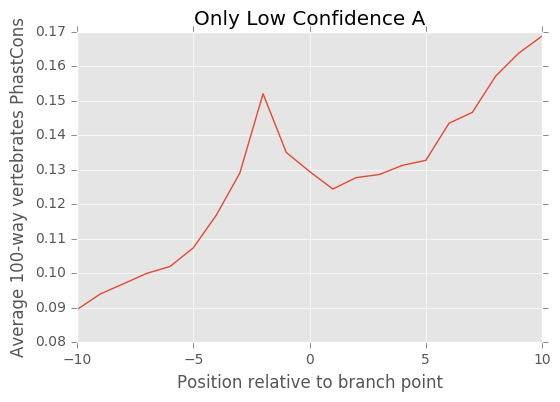

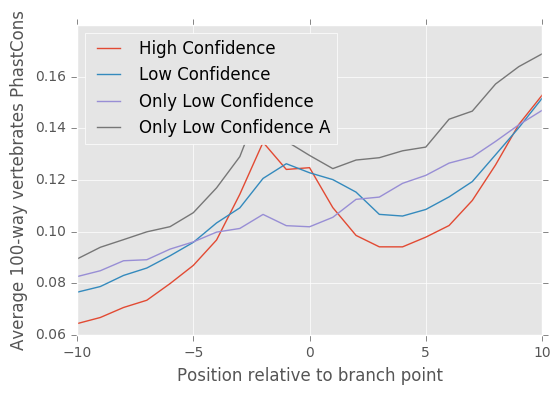

In [85]:
K = 10

def cons_known(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

def cons_not_close(X, high, low, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for h, l, seq in zip(high, low, X):
        for bp in np.nonzero(l)[0]:
            if sum(h[bp-2:bp+3]): continue
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

def cons_not_close_A(X, high, low, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for h, l, seq in zip(high, low, X):
        for bp in np.nonzero(l)[0]:
            if sum(h[bp-2:bp+3]): continue
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, 0]*seq[bp-2, 3]: continue
            counts = counts + seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

high = cons_known(X, y_high, 4)
low = cons_known(X, y_low, 4)
only_low = cons_not_close(X, y_high, y_low, 4)
only_low_A = cons_not_close_A(X, y_high, y_low, 4)

names = ['High Confidence',
         'Low Confidence',
         'Only Low Confidence',
         'Only Low Confidence A']
cons = [high, low, only_low, only_low_A]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
plt.legend(loc = 'best')
plt.show()

In [1]:
high = cons_known(X, y_high, 5)
low = cons_known(X, y_low, 5)
only_low = cons_not_close(X, y_high, y_low, 5)

names = ['High Confidence',
         'Low Confidence',
         'Only Low Confidence']
cons = [high, low, only_low]
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 'best')
plt.show()

NameError: name 'cons_known' is not defined

## Dists

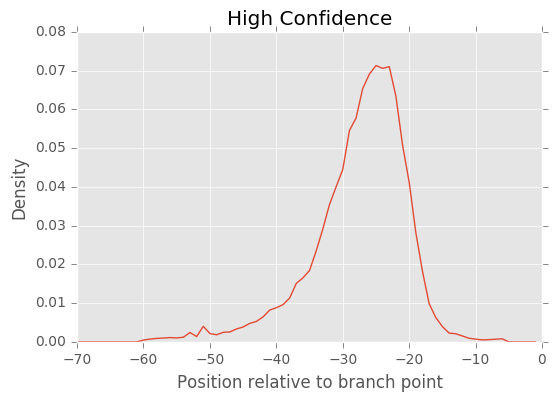

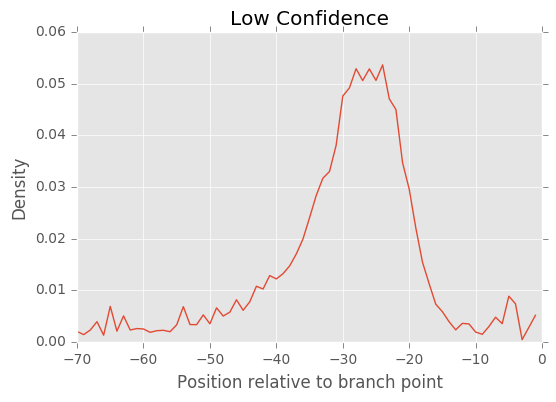

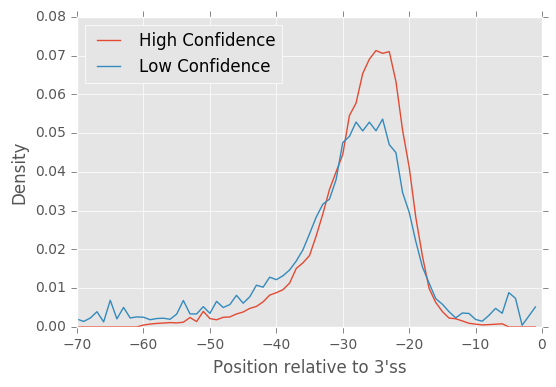

In [78]:
def dist_known(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            counts[bp] += 1
            total += 1
    return counts / total

high = dist_known(X, y_high, 4)
low = dist_known(X, y_low, 4)

dists = [high, low]

for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Density')
    plt.show()
    
for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist, label = name)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

## PWM

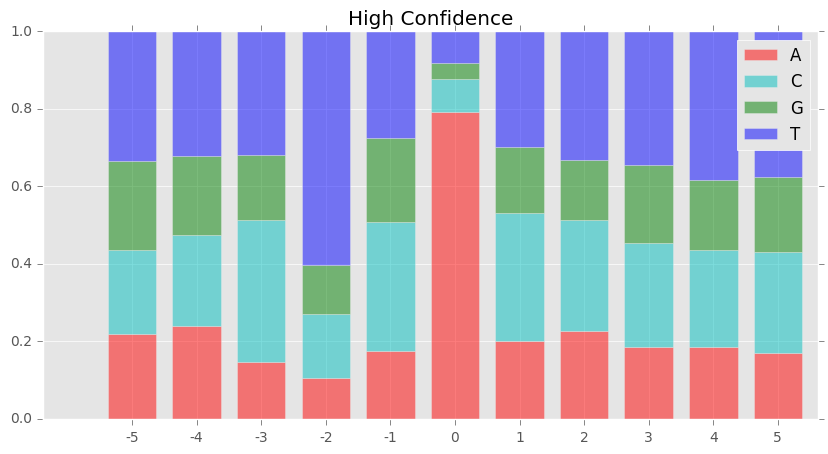

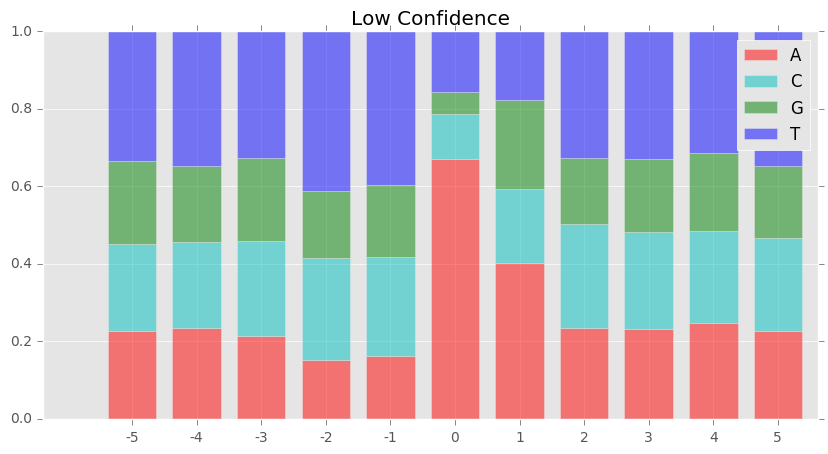

In [14]:
def pwm_logo(pwm, title):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_high, X):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm_logo(counts / total, names[0])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_low, X):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm_logo(counts / total, names[1])

[[ 0.0918543   0.          0.21503311  1.          0.13708609  0.21655629
   0.19639073]
 [ 0.4665894   0.          0.29887417  0.          0.37897351  0.26102649
   0.24427152]
 [ 0.15082781  0.          0.28337748  0.          0.14089404  0.17119205
   0.20897351]
 [ 0.29072848  1.          0.20271523  0.          0.34304636  0.35122517
   0.35036424]]


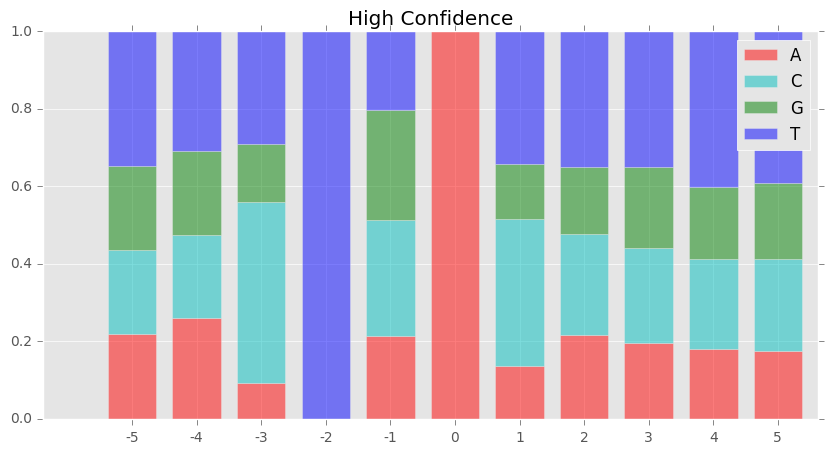

[[ 0.20469636  0.          0.27692308  1.          0.39789474  0.22753036
   0.25052632]
 [ 0.28469636  0.          0.14526316  0.          0.20259109  0.23497976
   0.19417004]
 [ 0.1794332   0.          0.26477733  0.          0.16744939  0.17700405
   0.17651822]
 [ 0.33117409  1.          0.31303644  0.          0.23206478  0.36048583
   0.37878543]]


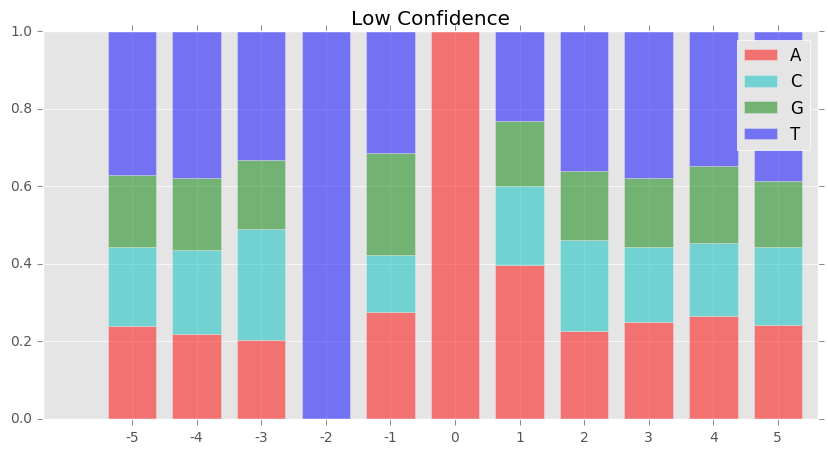

In [15]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_high, X):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if not (seq[bp-2, 3] and seq[bp, 0]): continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print (counts / total)[2:-2].T
pwm_logo(counts / total, names[0])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_low, X):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if not (seq[bp-2, 3] and seq[bp, 0]): continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print (counts / total)[2:-2].T
pwm_logo(counts / total, names[1])

56808


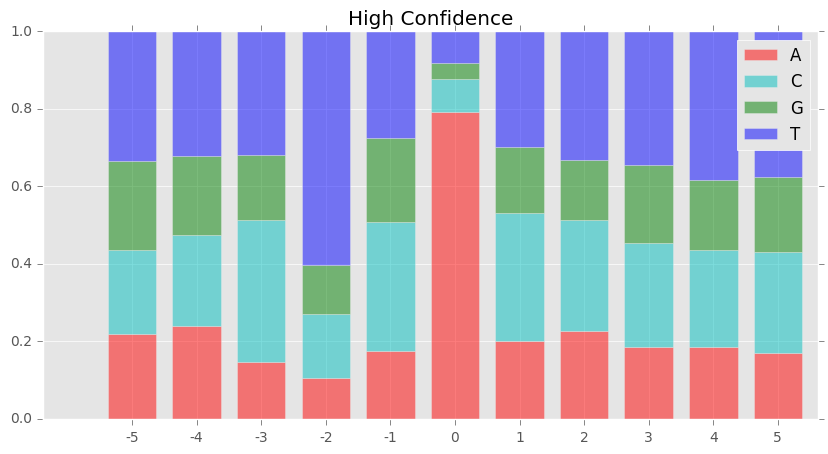

14821


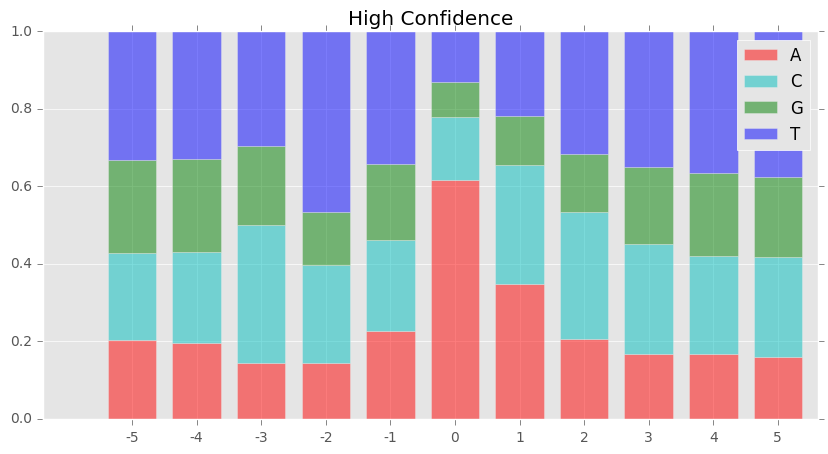

41987


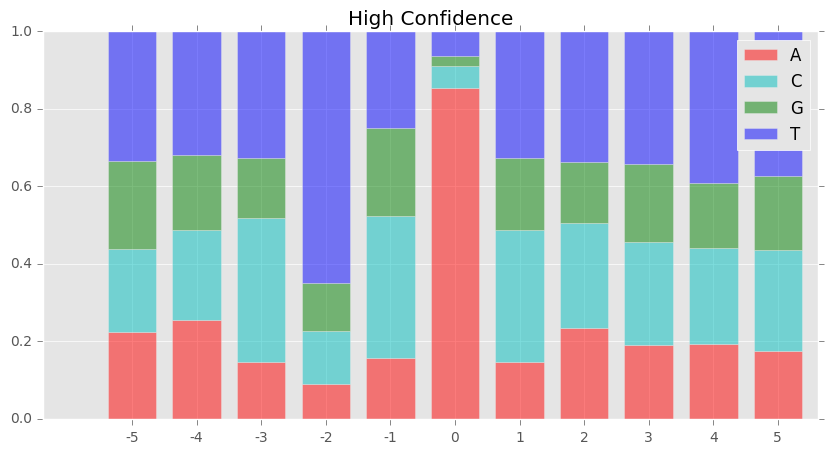

21571


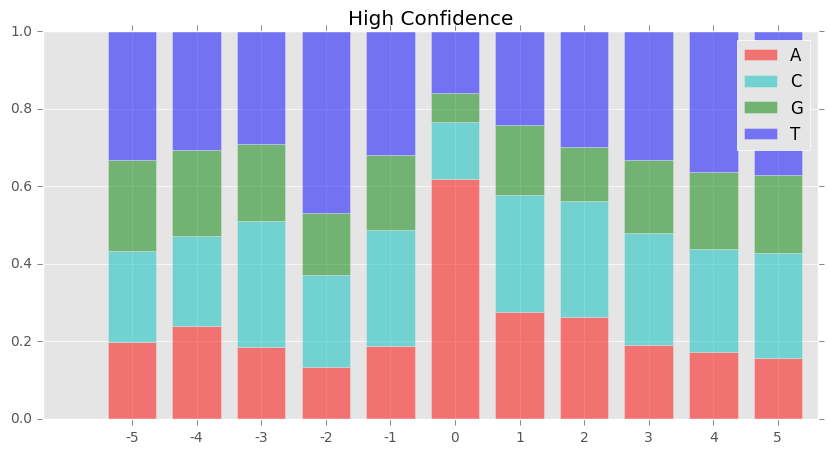

35237


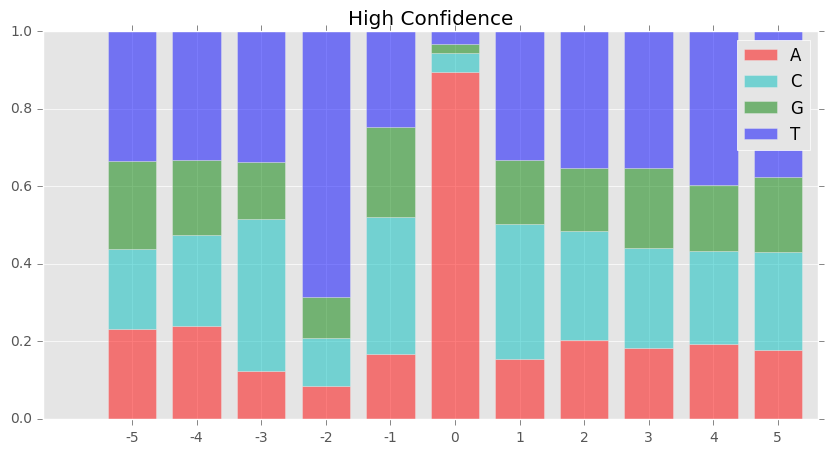

In [48]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and sum(high[bp-2:bp+2]) != 1): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and sum(high[bp-2:bp+2]) == 1): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and sum(high[bp-4:bp+4]) != 1): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and sum(high[bp-4:bp+4]) == 1): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

3679


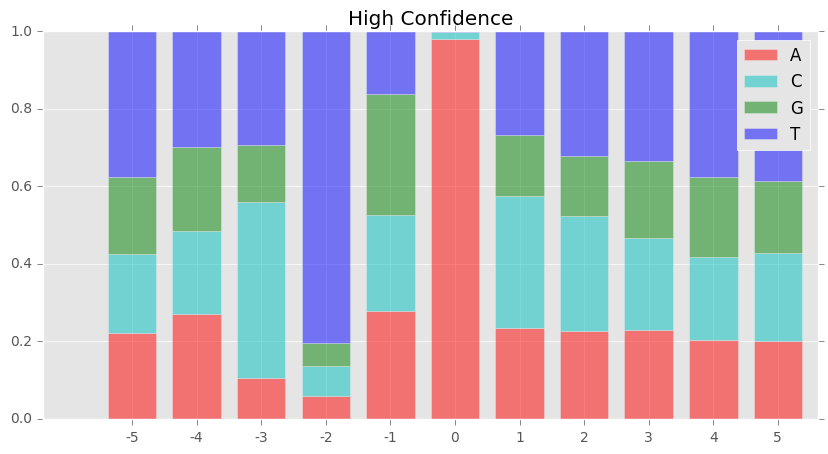

27664


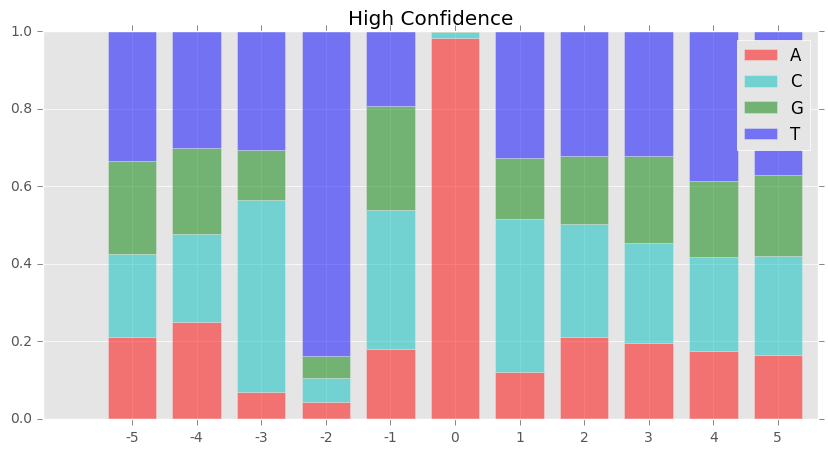

2795


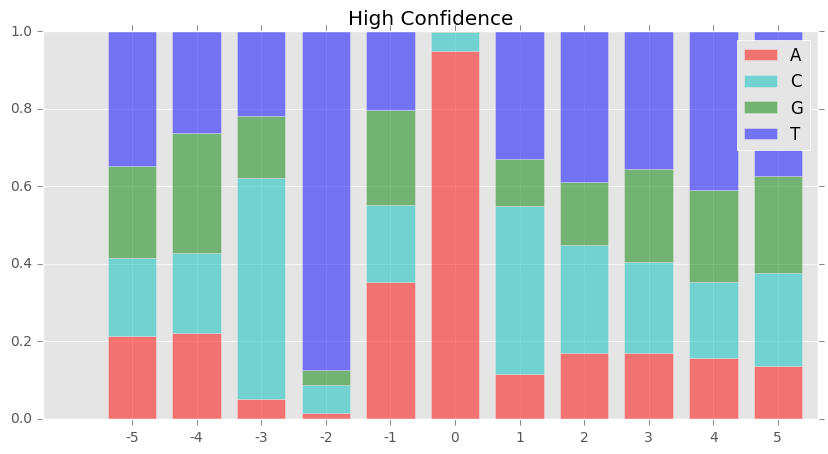

1188


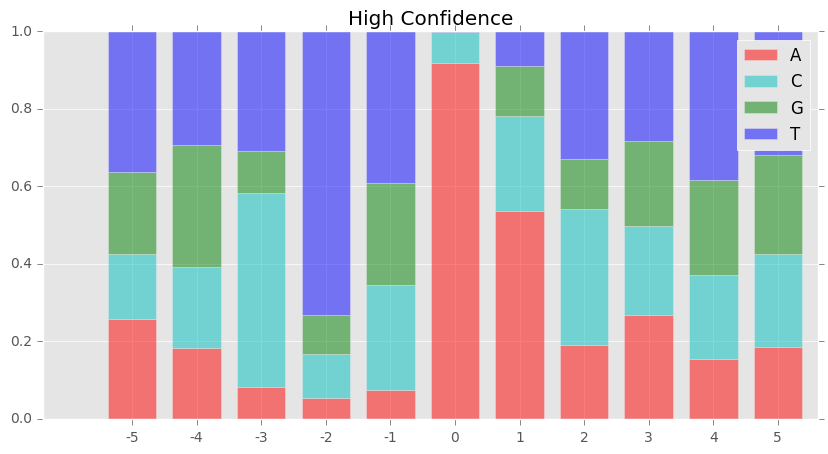

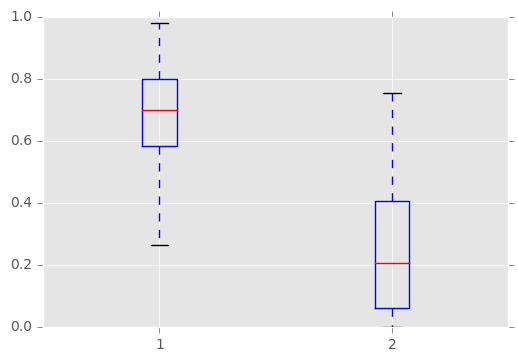

In [70]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq, pred in zip(y_high, y_low, X, preds):
    bp = np.argmax(pred.flatten())
    if not (low[bp] and high[bp]==0): continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq, pred in zip(y_high, y_low, X, preds):
    bp = np.argmax(pred.flatten())
    if not (high[bp]): continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq, pred in zip(y_high, y_low, X, preds):
    bp = np.argmax(pred.flatten())
    if not (high[bp] and high[bp-1]): continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
p1, p2 = [], []
for high, low, seq, pred in zip(y_high, y_low, X, preds):
    bp = np.argmax(pred.flatten())
    if not (high[bp] and high[bp+1]): continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    p1 += [pred[bp]]
    p2 += [pred[bp+1]]
    total += 1
print total
pwm_logo(counts / total, names[0])

plt.boxplot([p1, p2])
plt.show()

2121


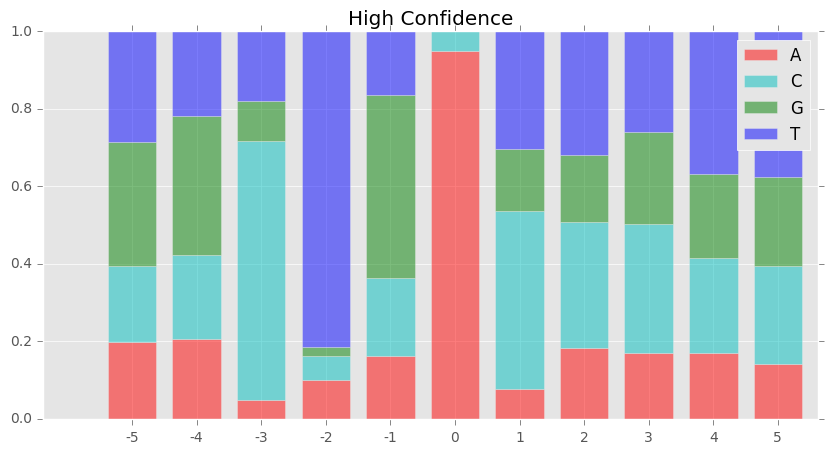

757


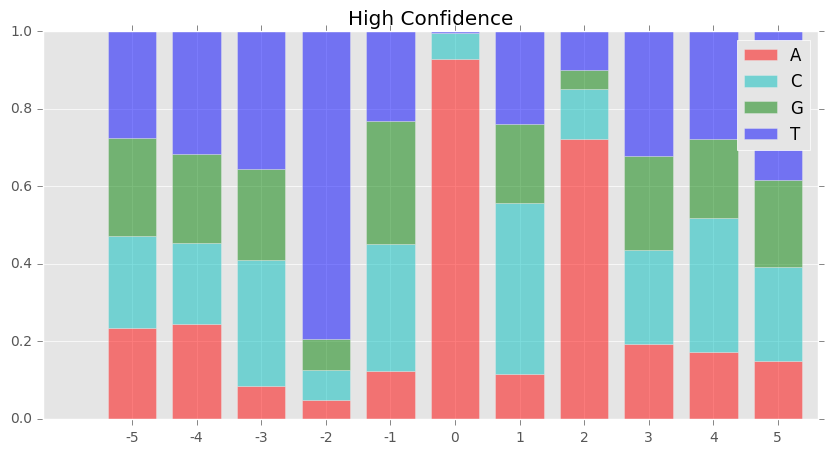

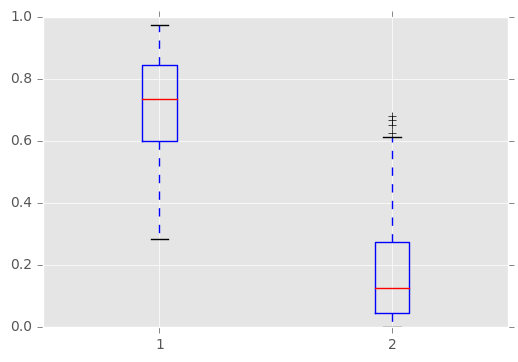

In [71]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq, pred in zip(y_high, y_low, X, preds):
    bp = np.argmax(pred.flatten())
    if not (high[bp] and high[bp-2]): continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
p1, p2 = [], []
for high, low, seq, pred in zip(y_high, y_low, X, preds):
    bp = np.argmax(pred.flatten())
    if not (high[bp] and high[bp+2]): continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    p1 +=[pred[bp]]
    p2 += [pred[bp+2]]
    total += 1
print total
pwm_logo(counts / total, names[0])

plt.boxplot([p1, p2])
plt.show()

3296
0.733313106796


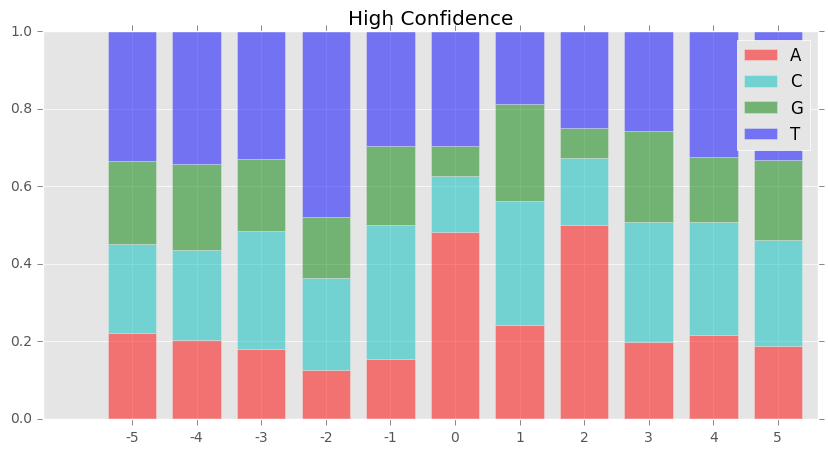

4896
0.801674836601


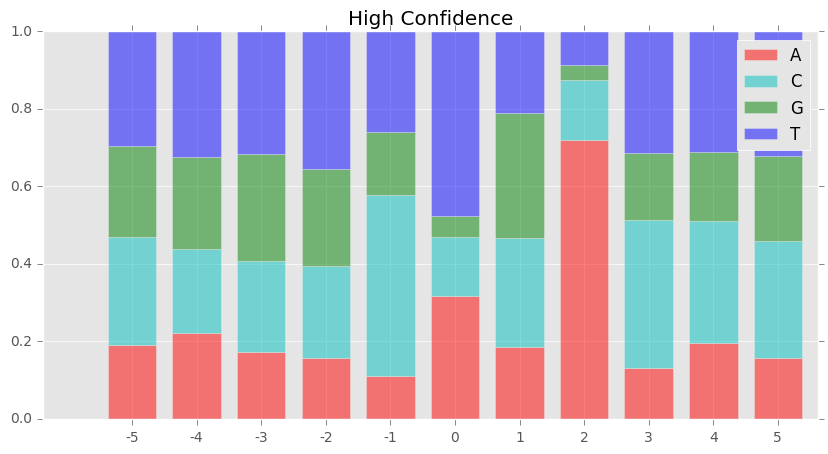

In [46]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
As = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and low[bp+2]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if seq[bp, 0] or seq[bp+2, 0]: As += 1
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
print As / float(total)
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
As = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and high[bp+2]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if seq[bp, 0] or seq[bp+2, 0]: As += 1
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
print As / float(total)
pwm_logo(counts / total, names[0])

5392


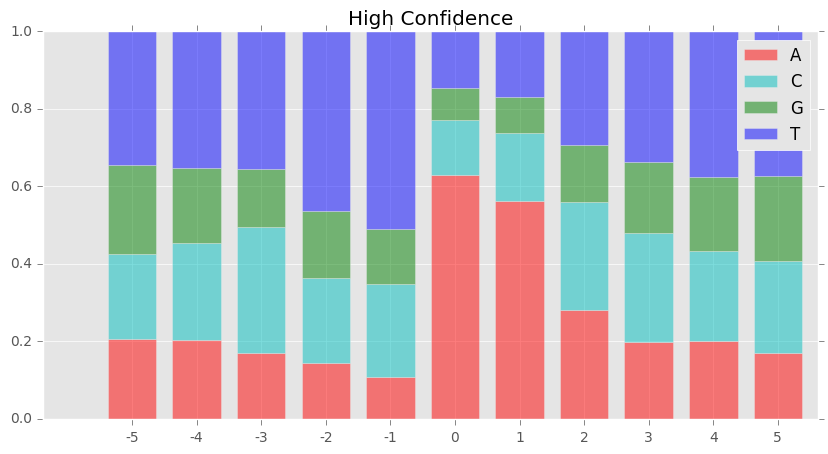

6662


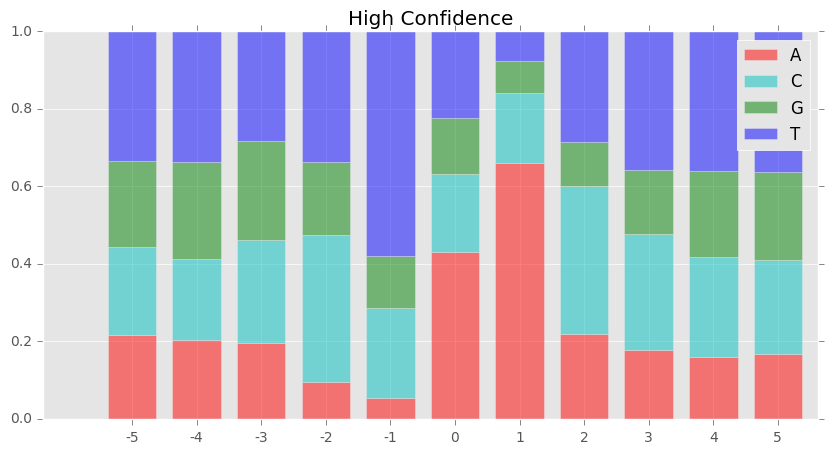

In [32]:
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and low[bp+1]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(L-1):
        if not (high[bp] and high[bp+1]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

9687


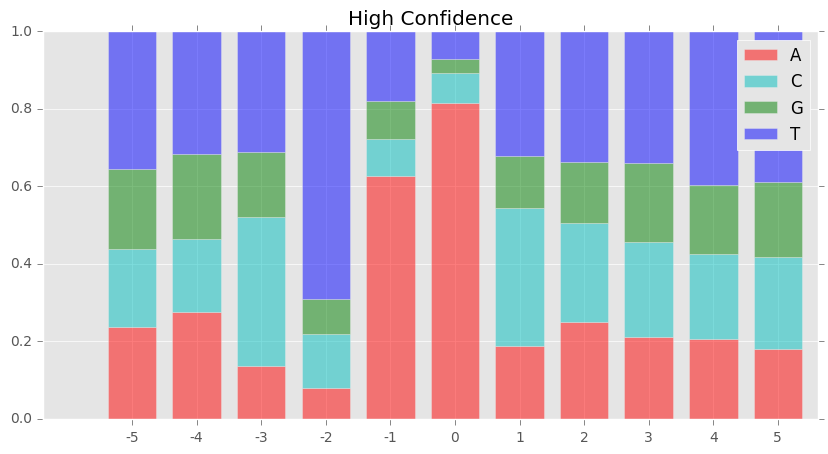

6662


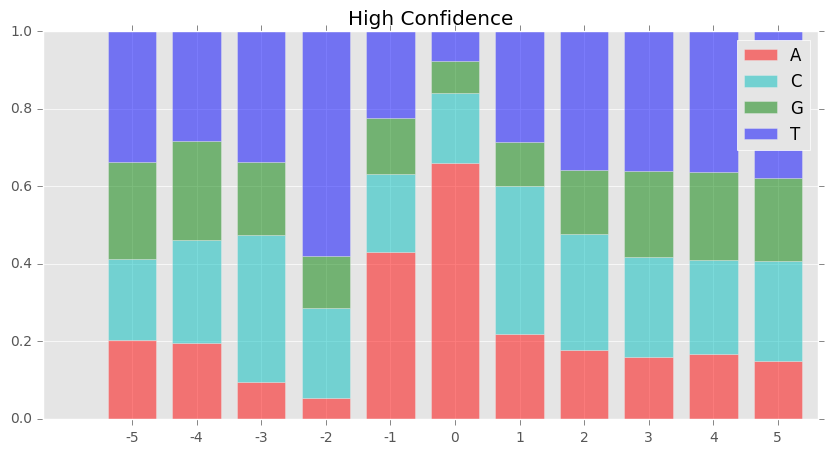

In [33]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(1, L):
        if not (high[bp] and low[bp-1]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(1, L):
        if not (high[bp] and high[bp-1]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])


3996


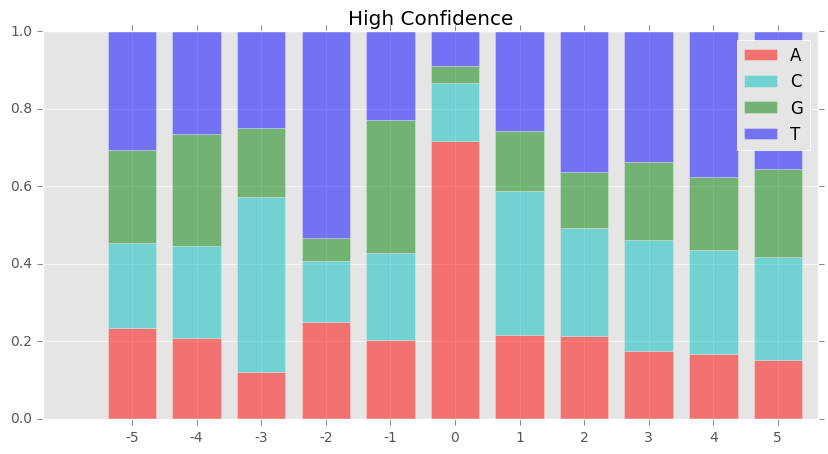

4896


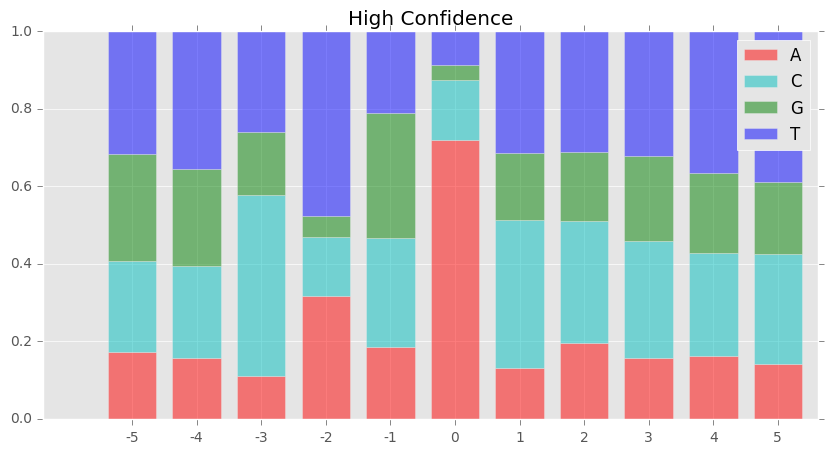

In [35]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(2, L):
        if not (high[bp] and low[bp-2]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(3, L):
        if not (high[bp] and high[bp-2]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

2987


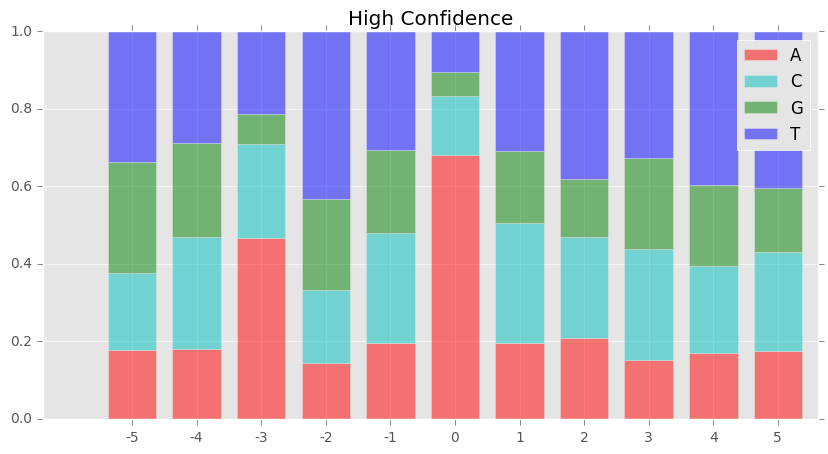

3059


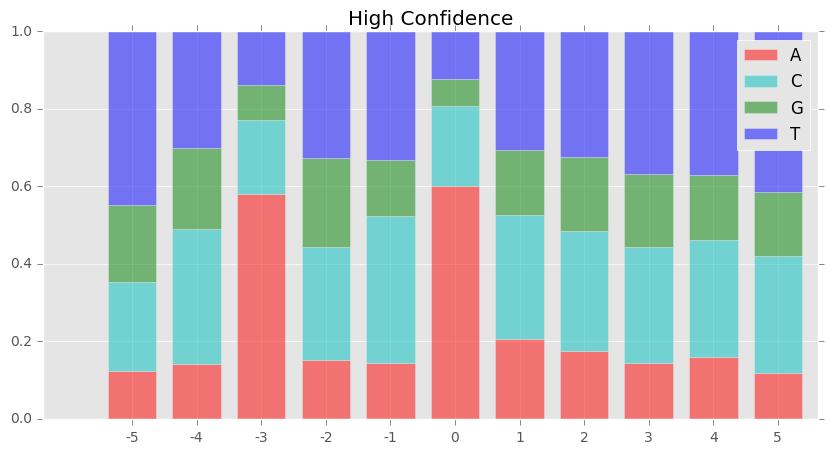

In [36]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(3, L):
        if not (high[bp] and low[bp-3]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(3, L):
        if not (high[bp] and high[bp-3]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

2755


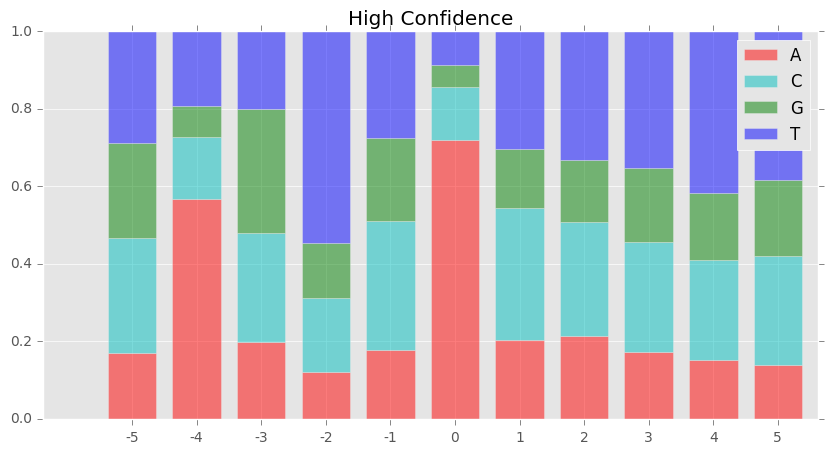

3084


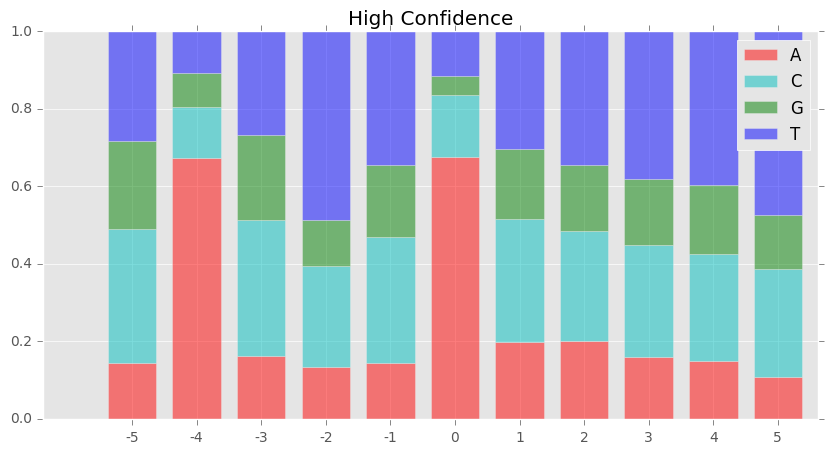

In [37]:
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(3, L):
        if not (high[bp] and low[bp-4]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for high, low, seq in zip(y_high, y_low, X):
    for bp in range(3, L):
        if not (high[bp] and high[bp-4]): continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, names[0])

## Variants

In [ ]:
from sklearn.utils import shuffle
import pandas
def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'))

pathogenic = read_variants('../../variants/hg19.pathogenicv2.features.tsv')
#path_indel = read_variants('../../hg19.allpathogenic.features.tsv')
#benign = read_variants('../../hg19.benign.exons.tsv')

In [17]:
# Make dict of chrom --> pos --> score

k_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, y_known):
    if chrom not in k_bps: k_bps[chrom] = {}
    for bp in np.nonzero(pred)[0]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        k_bps[chrom][idx] = strand

a_bps = {}
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, y_all):
    if chrom not in a_bps: a_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    a_bps[chrom][idx] = strand
    
n_bps = {}
for chrom, pos, strand, pred in zip(n_chroms, n_coords,
                                    n_strands, y_novel):
    if chrom not in n_bps: n_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    n_bps[chrom][idx] = strand
    
p_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, p_known):
    if chrom not in p_bps: p_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    p_bps[chrom][idx] = strand

NameError: name 'k_chroms' is not defined

Mercer et. al. branch points
chr10:50681659:-:-1
chr17:48273738:-:-1
chr13:49047468:+:-1
chr16:8898599:+:0
chr10:50681659:-:0
chr2:242680425:+:0
chrX:153131293:-:0
chr11:118959325:+:0
chrX:107845097:+:0
chrX:153788599:+:0
chr21:47409500:+:0
chr15:80464485:+:1
chr13:49047470:+:1
chr13:49047470:+:1
chr13:49047470:+:1
chrX:107845097:+:1
chr2:225368567:-:1
chr16:8898599:+:2
chr10:99511131:+:2
Predictions in Mercer introns
chr2:225368567:-:-2
chr13:49047468:+:-2
chr11:118959790:+:0
chr16:8898599:+:0
chr2:225368565:-:0
chr13:49047470:+:0
chr21:47409627:+:0
chr13:49047470:+:0
chr13:49047470:+:0
chr2:242680425:+:0
chr11:118959325:+:0
chrX:153788599:+:0
chr21:47409500:+:0
chr11:118959791:+:1
chr11:118959791:+:1
chr10:99511131:+:2
Novel predicted branch points
chr15:48818478:-:-3
chr11:108179837:-:-3
chrX:128674707:+:-3
chr11:46742048:+:-3
chr10:127477605:-:-3
chr2:128180582:+:-2
chr17:73748508:+:-2
chr11:2181258:-:-2
chr17:7124242:+:-2
chr17:73732344:+:-2
chr9:137686903:+:-2
chr5:127670562:-:-2

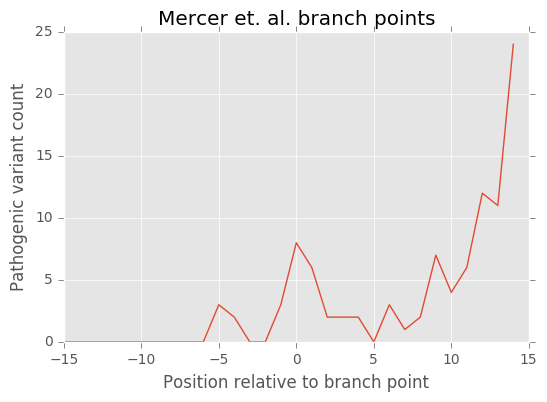

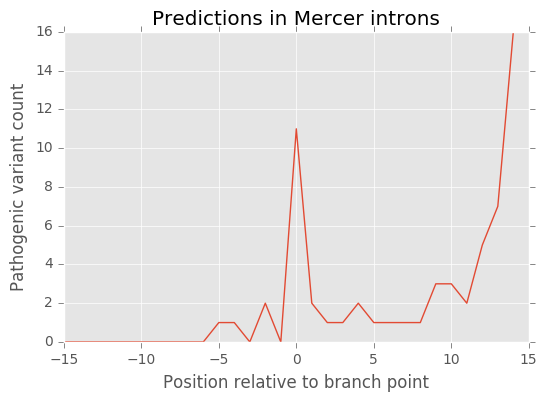

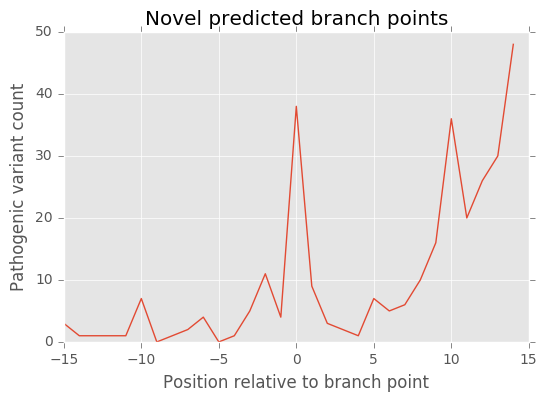

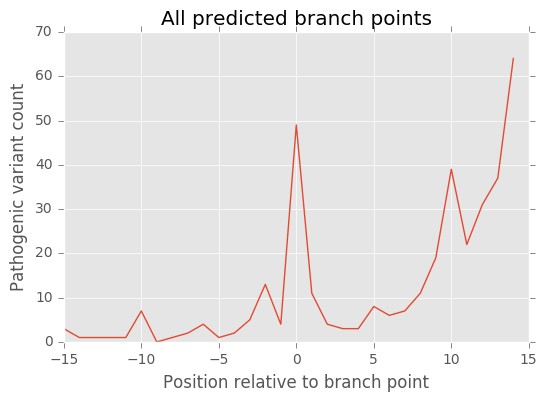

In [16]:
def var_enrichment(v, bps, report = []):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['CHROM'], v['POS'], v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
                if shift in report:
                    print "chr{}:{}:{}:{}".format(chrom, pos,
                                                  strand, shift)
    return hits

names = ['Mercer et. al. branch points',
         'Predictions in Mercer introns',
         'Novel predicted branch points',
         'All predicted branch points']
bps = [k_bps, p_bps, n_bps, a_bps]

path = []
for bp, name in zip(bps, names):
    print name
    path += [var_enrichment(pathogenic, bp, range(-3, 3))]

for name, hits in zip(names, path):
    plt.plot(range(-15, 15), hits)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("Pathogenic variant count")
    plt.show()

In [29]:
print path_indel['POS'][16044]

POS


In [18]:
path_indels = []
for bp in bps:
    path_indels += [var_enrichment(path_indel, bp, range(-3, 3))]

for name, hits in zip(names, path_indels):
    plt.plot(range(-15, 15), hits)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("Pathogenic variant count")
    plt.show()

TypeError: cannot concatenate 'str' and 'int' objects

In [ ]:
exac = []
for bp in bps:
    exac += [var_enrichment(benign, bp, [])]

for name, hits in zip(names, exac):
    plt.plot(range(-15, 15), hits)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("ExAC variant count")
    plt.show()

In [ ]:
hifq, lofq = [], []
for bp in bps:
    hifq += [var_enrichment(benign[benign['ALFQMAX'] >= .0001], bp, [])]
    lofq += [var_enrichment(benign[benign['ALFQMAX'] <  .0001], bp, [])]

for name, hi, lo in zip(names, hifq, lofq):
    plt.plot(range(-15, 15), np.array(hi)/float(sum(hi)),
             label='ALFQ >= .0001')
    plt.plot(range(-15, 15), np.array(lo)/float(sum(lo)),
             label = 'ALFQ < .0001')
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("ExAC variant density")
    plt.legend(loc = 'best')
    plt.show()